In [53]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures

from env import host, user, password

In [2]:
def get_db_url(db_name):
    """
    This function uses my env file to get the url to access the Codeup database.
    It takes in a string identifying the database I want to connect to.
    """
    return f"mysql+pymysql://{user}:{password}@{host}/{db_name}"




def get_data_from_sql(str_db_name, query):
    """
    This function takes in a string for the name of the database I want to connect to
    and a query to obtain my data from the Codeup server and return a DataFrame.
    """
    df = pd.read_sql(query, get_db_url('zillow'))
    return df

def get_zillow_mvp():
    query = """
select 
bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,taxvaluedollarcnt, transactiondate
FROM properties_2017
join propertylandusetype using (propertylandusetypeid)
join predictions_2017 using (parcelid)
where propertylandusedesc = "Single Family Residential"
;
    """
    df = get_data_from_sql("zillow", query)
    return df

In [3]:
df=get_zillow_mvp()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52442 non-null  float64
 1   bathroomcnt                   52442 non-null  float64
 2   calculatedfinishedsquarefeet  52360 non-null  float64
 3   taxvaluedollarcnt             52441 non-null  float64
 4   transactiondate               52442 non-null  object 
dtypes: float64(4), object(1)
memory usage: 2.0+ MB


In [5]:
def optimize_types(df):
    # Convert some columns to integers
    # bathroom, and bedrooms can be integers
    df["bathroomcnt"] = df["bathroomcnt"].astype(int)
    df["bedroomcnt"] = df["bedroomcnt"].astype(int)    
    df["taxvaluedollarcnt"] = df["taxvaluedollarcnt"].astype(int)
    df["calculatedfinishedsquarefeet"] = df["calculatedfinishedsquarefeet"].astype(int)
    return df

def handle_outliers(df):
    """Manually handle outliers that do not represent properties likely for 99% of buyers and zillow visitors"""
    df = df[df.bathroomcnt <= 6]
    
    df = df[df.bedroomcnt <= 6]

    df = df[df.taxvaluedollarcnt < 2_000_000]

    return df
def handle_nulls(df):    
    # We keep 99.41% of the data after dropping nulls
    # round(df.dropna().shape[0] / df.shape[0], 4) returned .9941
    df = df.dropna()
    return df

In [6]:
def wrangle_zillow(df):
    """
    Acquires Zillow data
    Handles nulls
    optimizes or fixes data types
    handles outliers w/ manual logic
    returns a clean dataframe
    """
    #df = get_zillow_data()

    df = handle_nulls(df)

    df = optimize_types(df)

    df = handle_outliers(df)

    return df

In [7]:
df=wrangle_zillow(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50851 entries, 0 to 52441
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   bedroomcnt                    50851 non-null  int64 
 1   bathroomcnt                   50851 non-null  int64 
 2   calculatedfinishedsquarefeet  50851 non-null  int64 
 3   taxvaluedollarcnt             50851 non-null  int64 
 4   transactiondate               50851 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.3+ MB


In [12]:
# renaming columns
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value'})

In [50]:
def train_validate_test(df, target):
    """
    this function takes in a dataframe and splits it into 3 samples,
    a test, which is 20% of the entire dataframe,
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe.
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable.
    The function returns 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test.
    """
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=0.2, random_state=123)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=123)

    # split train into X (dataframe, drop target) & y (series, keep target only)
    x_train = train.drop(columns=[target])
    y_train = train[target]

    # split validate into X (dataframe, drop target) & y (series, keep target only)
    x_validate = validate.drop(columns=[target])
    y_validate = validate[target]

    # split test into X (dataframe, drop target) & y (series, keep target only)
    x_test = test.drop(columns=[target])
    y_test = test[target]

    return train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test

In [51]:
train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test=train_validate_test(df,'tax_value')

In [41]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28476 entries, 7606 to 45176
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bedrooms         28476 non-null  int64 
 1   bathrooms        28476 non-null  int64 
 2   area             28476 non-null  int64 
 3   transactiondate  28476 non-null  object
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


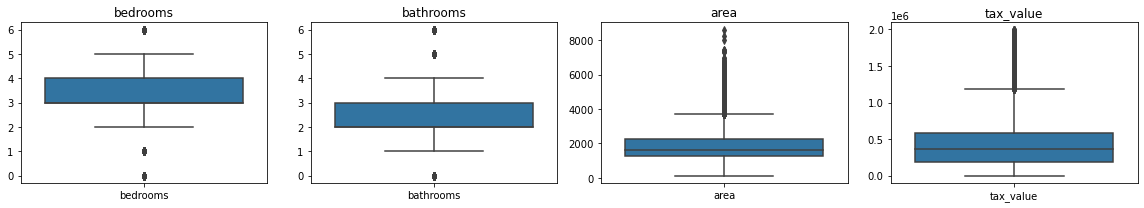

In [42]:
# List of columns
cols = ['bedrooms', 'bathrooms', 'area', 'tax_value']

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)

    # sets proper spacing between plots
    plt.tight_layout()
    
plt.show()

In [43]:
def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df if col not in ['transactiondate']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()
        
        
def get_box(df):
    ''' Gets boxplots of acquired continuous variables'''
    
    # List of columns
    cols = ['bedrooms', 'bathrooms', 'area', 'tax_value']

    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):

        # i starts at 0, but plot should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display boxplot for column.
        sns.boxplot(data=df[[col]])

        # Hide gridlines.
        plt.grid(False)

        # sets proper spacing between plots
        plt.tight_layout()

    plt.show()

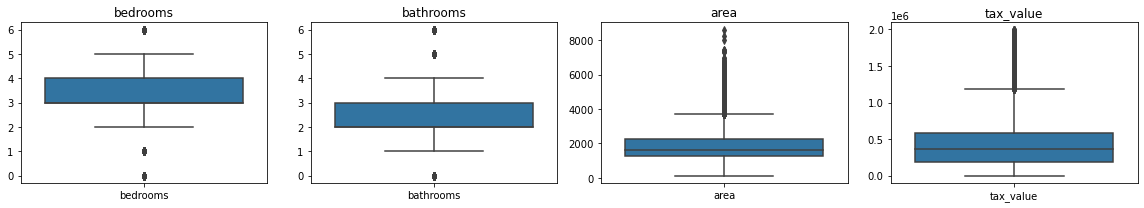

In [44]:

get_box(df)

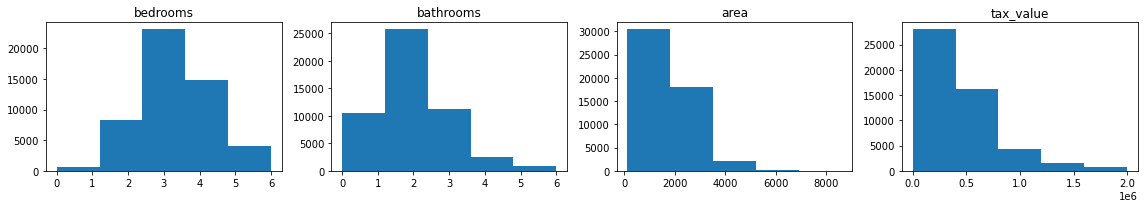

In [45]:
get_hist(df)

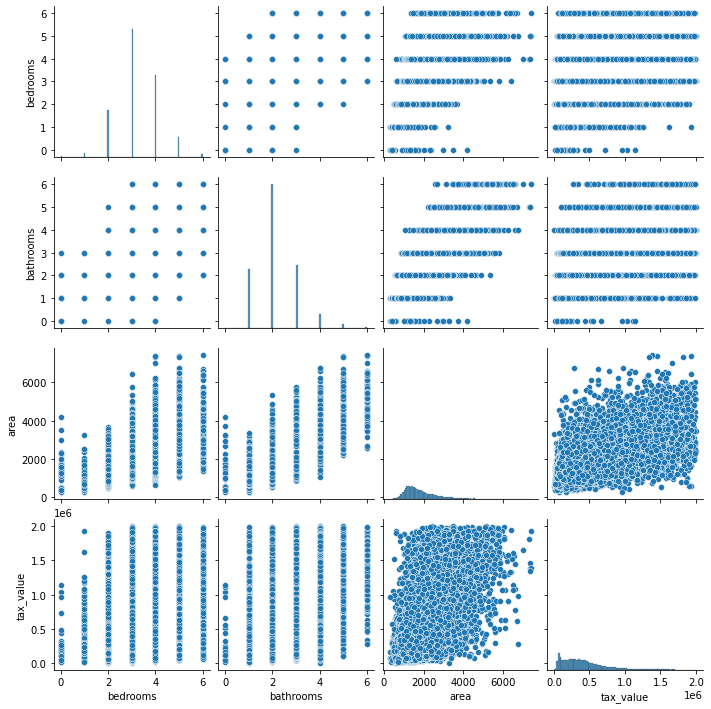

In [52]:
sns.pairplot(train)


In [60]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 28476 entries, 7606 to 45176
Series name: tax_value
Non-Null Count  Dtype
--------------  -----
28476 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


In [61]:
y_train['baseline_mean'] = y_train.mean()
y_train['baseline_median'] = y_train.median()

# scores:
rmse_mean = mean_squared_error(y_train,
                               y_train['baseline_mean'], squared=False)
rmse_med = mean_squared_error(y_train,
                               y_train['baseline_median'], squared=False)

rmse_mean, rmse_med

TypeError: Singleton array 445991.33937350754 cannot be considered a valid collection.